In [122]:
import cv2 as cv
import numpy as np
import imutils
import matplotlib
from matplotlib import pyplot as plt
import os
from PIL import Image, ImageEnhance

class Preprocessing:
    
    def __init__(self, datapath):
        self.datapath = datapath
        self.__images=None
        self.__uplighting=None
        self.__downlighting=None
        self.__mask=None
        self.__load_images()
        self.__load_mask()
        self.__data_augmentation()
    
    def __load_images(self):
        """
        Load all the images from datapath. 
        """
        if not os.path.exists(os.path.join(self.datapath, 'hands_resized')):
            print(f"The specified folder path '{self.datapath}' does not exist.")
        else:
            # Get a list of all files in the specified folder
            files = os.listdir(os.path.join(self.datapath, 'hands_resized'))
            image_files = [f for f in files if f.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]  

            # List to store the loaded images
            loaded_images = []

            # Loop through each image file and load it using OpenCV
            for image_file in image_files:
                image_folder = os.path.join(self.datapath, 'hands_resized')
                image_path = os.path.join(image_folder, image_file)
                img = cv.imread(image_path)

                if img is not None:
                    # Append the loaded image to the list
                    cv_image_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

                    loaded_images.append(cv_image_rgb)
            self.__images=loaded_images
            
    def __load_mask(self):
        """
        Load all the masks from datapath. 
        """
        if not os.path.exists(os.path.join(self.datapath, 'masks_new')):
            print(f"The specified folder path '{self.datapath}' does not exist.")
        else:
            # Get a list of all files in the specified folder
            files = os.listdir(os.path.join(self.datapath, 'masks_new'))
            image_files = [f for f in files if f.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]  

            # List to store the loaded images
            loaded_images = []

            # Loop through each image file and load it using OpenCV
            for image_file in image_files:
                image_folder = os.path.join(self.datapath, 'masks_new')
                image_path = os.path.join(image_folder, image_file)
                img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

                if img is not None:
                    # Append the loaded image to the list
                    loaded_images.append(img)
            self.__mask=loaded_images
            
            
    def __data_augmentation(self):
        """
        Change the lightling of the images
        """
        # Convert OpenCV images to PIL images
        pil_images = []
        for cv_image in self.__images:
            # Convert BGR to RGB as PIL works with RGB
            #cv_image_rgb = cv.cvtColor(cv_image, cv.COLOR_BGR2RGB)
            pil_image = Image.fromarray(cv_image)
            pil_images.append(pil_image)
        # Enhance the brightness to generate versions with different lighting conditions
        generated_images_cv2_up=[]
        generated_images_cv2_down=[]
        for pil_image in pil_images:
            # Create an ImageEnhance object
            enhancer = ImageEnhance.Brightness(pil_image)

            # Generate the version with poor lighting (reduced brightness)
            poor_brightness = enhancer.enhance(0.5)
            #poor_brightness_cv2 = cv.cvtColor(np.array(poor_brightness), cv.COLOR_RGB2BGR)
            generated_images_cv2_down.append(np.array(poor_brightness))

            # Generate the version with too bright lighting
            too_bright = enhancer.enhance(1.5)
            #too_bright_cv2 = cv.cvtColor(np.array(too_bright), cv.COLOR_RGB2BGR)
            generated_images_cv2_up.append(np.array(too_bright))
        self.__uplighting=generated_images_cv2_up
        self.__downlighting=generated_images_cv2_down
        
        pass
    def get_images(self):
        """
        Return the images
        """
        return self.__images, self.__uplighting, self.__downlighting, self.__mask

In [123]:
DATAPATH= 'hands/'


In [124]:
preprocessing = Preprocessing(DATAPATH)
images , uplighting, downlighting, mask = preprocessing.get_images()
print(len(images))
print(len(uplighting))
print(len(downlighting))
print(len(mask))

4
4
4
4


# Analysis of YCrCb signals


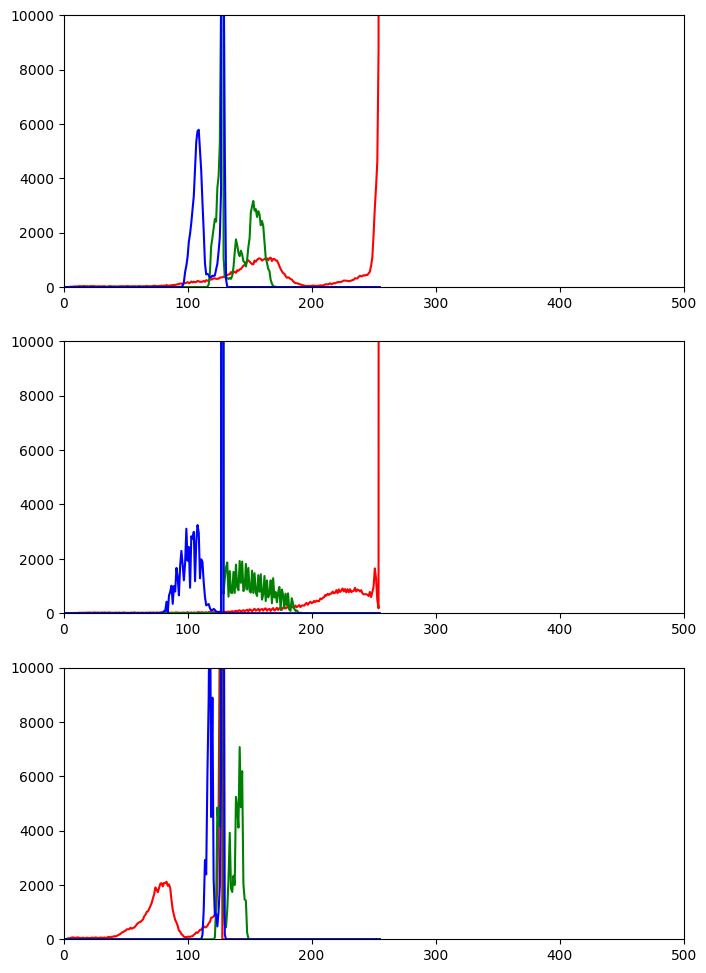

In [254]:
imageYCrCbNormal = cv.cvtColor(images[0],cv.COLOR_RGB2YCR_CB)
imageYCrCbUp = cv.cvtColor(uplighting[0],cv.COLOR_RGB2YCR_CB)
imageYCrCbDown = cv.cvtColor(downlighting[0],cv.COLOR_RGB2YCR_CB)
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

color = ('r','g','b')
for i,col in enumerate(color):
    histr = cv.calcHist([imageYCrCbNormal],[i],None,[256],[0,256])
    axes[0].set_xlim(0,500)
    axes[0].set_ylim(0,10000)
    axes[0].plot(histr,color = col)
    
for i,col in enumerate(color):
    histr = cv.calcHist([imageYCrCbUp],[i],None,[256],[0,256])
    axes[1].set_xlim(0,500)
    axes[1].set_ylim(0,10000)
    axes[1].plot(histr,color = col)
for i,col in enumerate(color):
    histr = cv.calcHist([imageYCrCbDown],[i],None,[256],[0,256])
    axes[2].set_xlim(0,500)
    axes[2].set_ylim(0,10000)
    axes[2].plot(histr,color = col)

In [255]:
def precision_metric(skinRegion, mask):
    """
    Calculate the precision metric
    """
    # Convert the mask to binary
    mask = mask.astype(bool)
    skinRegion = skinRegion.astype(bool)

    # Calculate the precision metric
    precision = np.sum(np.logical_and(mask, skinRegion)) / np.sum(skinRegion)
    return precision


In [279]:
def average_precison(lower, upper, cvConst, images):
    sum_p=0
    for i in range(len(images)):
        imageYCrCb = cv.cvtColor(images[i],cvConst)
        skinRegion = cv.inRange(imageYCrCb,lower,upper)
        _, binary_image = cv.threshold(mask[i], 2, 1, cv.THRESH_BINARY)
        sum_p+=precision_metric(skinRegion, binary_image)
        print(precision_metric(skinRegion, binary_image))
    print(sum_p/len(images))

In [274]:
lower = np.array([0,133, 77])
upper = np.array([255, 173, 127])

In [275]:
 # Convert image to YCrCb
imageYCrCb = cv.cvtColor(images[0],cv.COLOR_RGB2YCR_CB)

    # Find region with skin tone in YCrCb image
skinRegion = cv.inRange(imageYCrCb,lower,upper)

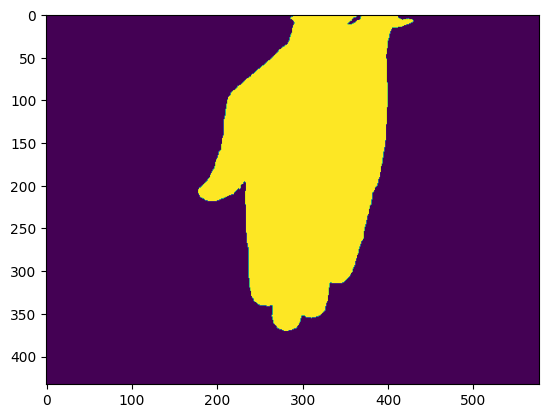

In [258]:
#plot
plt.imshow(skinRegion)

In [259]:
_, binary_image = cv.threshold(mask[0], 2, 1, cv.THRESH_BINARY)

In [260]:
precision_metric(skinRegion, binary_image)

0.9862998294506813

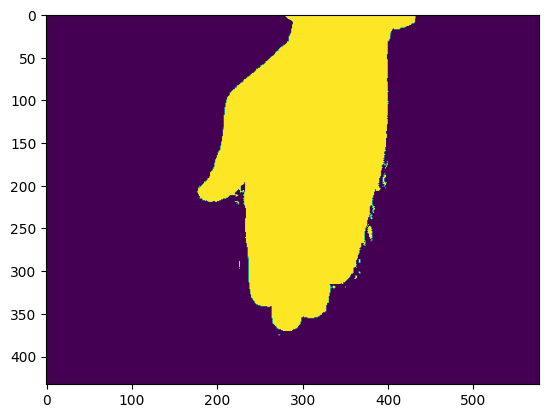

In [261]:
 # Convert image to YCrCb
lower_down = np.array([0,129, 77])
upper_down = np.array([150, 150, 127])
imageYCrCb = cv.cvtColor(downlighting[0],cv.COLOR_RGB2YCR_CB)

    # Find region with skin tone in YCrCb image
skinRegion = cv.inRange(imageYCrCb,lower_down,upper_down)
plt.imshow(skinRegion)

In [262]:
precision_metric(skinRegion, binary_image)

0.9696759089911479

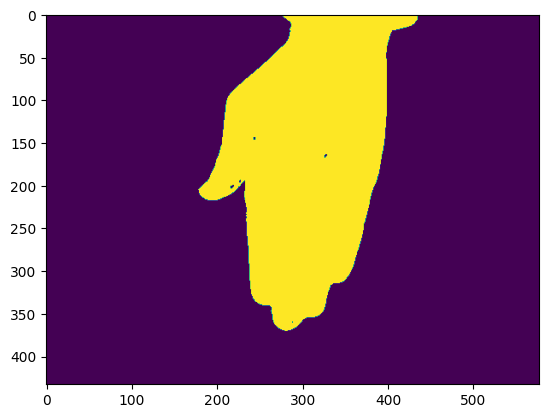

In [263]:
 # Convert image to YCrCb
lower_up = np.array([0,120, 77])
upper_up = np.array([255, 190, 127])
imageYCrCb = cv.cvtColor(uplighting[0],cv.COLOR_RGB2YCR_CB)

    # Find region with skin tone in YCrCb image
skinRegion = cv.inRange(imageYCrCb,lower_up,upper_up)
plt.imshow(skinRegion)

In [264]:
precision_metric(skinRegion, binary_image)

0.9909249106524709

In [280]:

average_precison(lower, upper, cv.COLOR_RGB2YCR_CB, images)

0.9862998294506813
0.9692957047090954
0.9474375613307587
0.9388543391048871
0.9604718586488556


In [281]:
average_precison(lower_down, upper_down, cv.COLOR_RGB2YCR_CB, downlighting)

0.9696759089911479
0.9412774616093854
0.9089074575105757
0.8888248361969573
0.9271714160770166


In [282]:
average_precison(lower_up, upper_up, cv.COLOR_RGB2YCR_CB, uplighting)

0.9909249106524709
0.9784354810546534
0.9583758382527552
0.9326272827479369
0.965090878176954


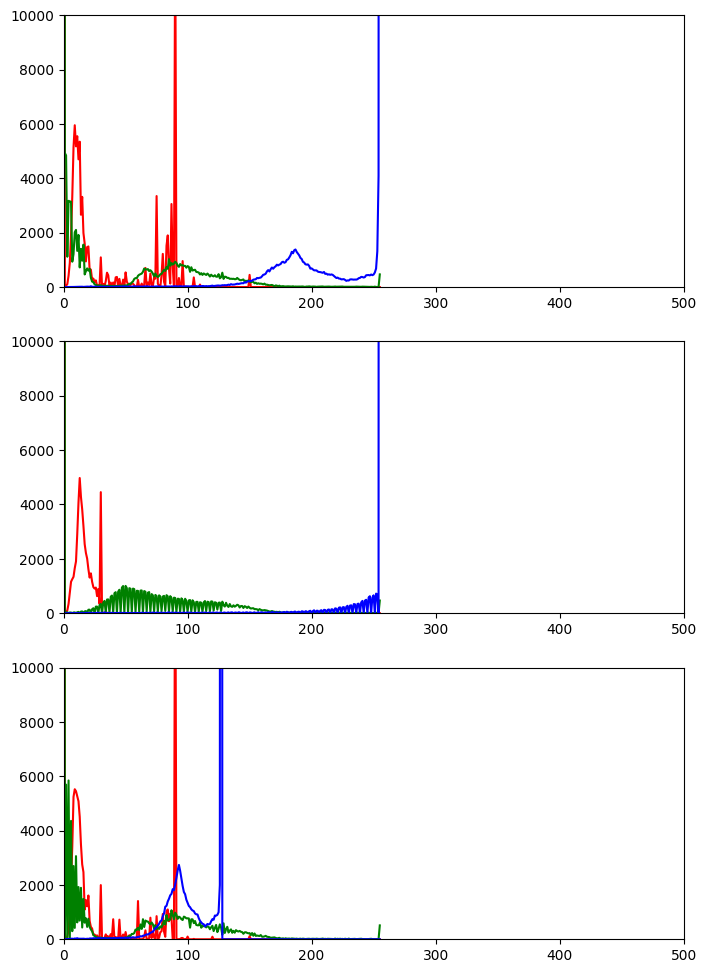

In [283]:
imageYCrCbNormal = cv.cvtColor(images[0],cv.COLOR_RGB2HSV)
imageYCrCbUp = cv.cvtColor(uplighting[0],cv.COLOR_RGB2HSV)
imageYCrCbDown = cv.cvtColor(downlighting[0],cv.COLOR_RGB2HSV)
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

color = ('r','g','b')
for i,col in enumerate(color):
    histr = cv.calcHist([imageYCrCbNormal],[i],None,[256],[0,256])
    axes[0].set_xlim(0,500)
    axes[0].set_ylim(0,10000)
    axes[0].plot(histr,color = col)
    
for i,col in enumerate(color):
    histr = cv.calcHist([imageYCrCbUp],[i],None,[256],[0,256])
    axes[1].set_xlim(0,500)
    axes[1].set_ylim(0,10000)
    axes[1].plot(histr,color = col)
for i,col in enumerate(color):
    histr = cv.calcHist([imageYCrCbDown],[i],None,[256],[0,256])
    axes[2].set_xlim(0,500)
    axes[2].set_ylim(0,10000)
    axes[2].plot(histr,color = col)

In [289]:
lower = np.array([0,50, 0])
upper = np.array([200, 255, 255])

In [290]:
imageYCrCb = cv.cvtColor(images[0],cv.COLOR_RGB2HSV)

    # Find region with skin tone in YCrCb image
skinRegion = cv.inRange(imageYCrCb,lower,upper)

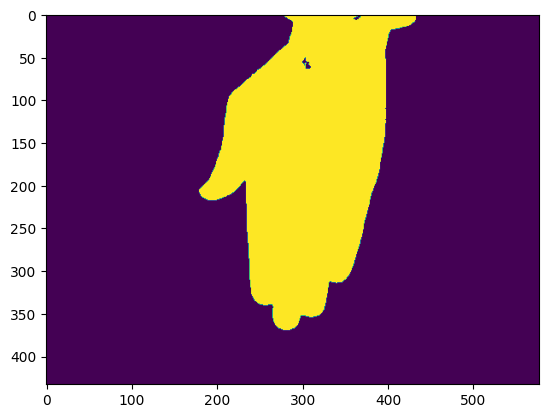

In [291]:
plt.imshow(skinRegion)

In [292]:
_, binary_image = cv.threshold(mask[0], 2, 1, cv.THRESH_BINARY)
precision_metric(skinRegion, binary_image)

0.9949149004800486

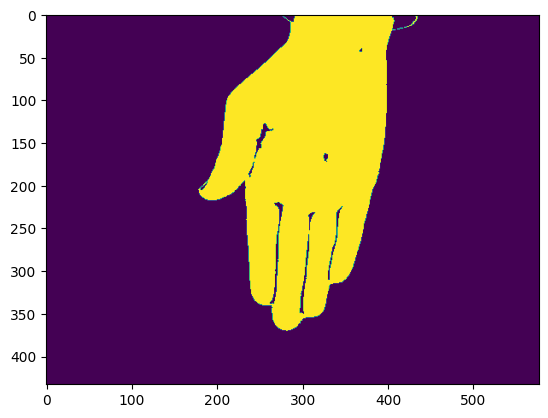

In [293]:
lower_up = np.array([0,10, 150])
upper_up = np.array([100, 255, 255])
imageYCrCb = cv.cvtColor(uplighting[0],cv.COLOR_RGB2HSV)

    # Find region with skin tone in YCrCb image
skinRegion = cv.inRange(imageYCrCb,lower_up,upper_up)
plt.imshow(skinRegion)

In [294]:
_, binary_image = cv.threshold(mask[0], 2, 1, cv.THRESH_BINARY)
precision_metric(skinRegion, binary_image)

0.9949472547393593

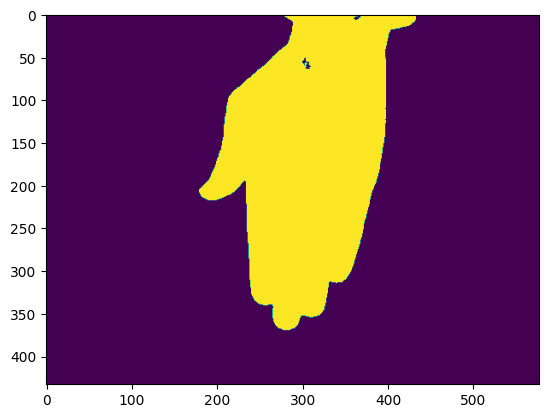

In [295]:
lower_down = np.array([0,50, 0])
upper_down = np.array([200, 255, 255])
imageYCrCb = cv.cvtColor(downlighting[0],cv.COLOR_RGB2HSV)

    # Find region with skin tone in YCrCb image
skinRegion = cv.inRange(imageYCrCb,lower_down,upper_down)
plt.imshow(skinRegion)

In [296]:
_, binary_image = cv.threshold(mask[0], 2, 1, cv.THRESH_BINARY)
precision_metric(skinRegion, binary_image)

0.9949160580479939

In [297]:
average_precison(lower, upper, cv.COLOR_RGB2HSV, images)


0.9949149004800486
0.9904302815774026
0.9752196866777871
0.9688081427164277
0.9823432528629165


In [299]:
average_precison(lower_up, upper_up, cv.COLOR_RGB2HSV, uplighting)

0.9949472547393593
0.9816023738872404
0.9612996651280659
0.9379058626720401
0.9689387891066764


In [300]:
average_precison(lower_down, upper_down, cv.COLOR_RGB2HSV, downlighting)

0.9949160580479939
0.990443710256137
0.9750369377727383
0.9683973617579944
0.982198516958716
